In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [2]:
data = pd.read_excel('Zenith angle vs. coincident count rate.xlsx')

In [3]:
data

,Zenith angle,Avg. count per hour
0,0,11.4
1,9,11.5
2,19,10.1
3,28,8.8
4,34,8.3
5,40,7.7
6,45,5.8
7,53,5.6
8,66,3.1
9,70,3.0


In [4]:
X = data.iloc[:,0].values
y = data.iloc[:,1].values

In [5]:
from scipy import optimize

### func1 = aCos(x)^n+b

In [6]:
def func1(x, a, n, b):
    return a*np.cos(np.deg2rad(X))**n + b

In [7]:
popt_func1, pcov_func1 = optimize.curve_fit(func1, X, y, p0=[1, 0, 0])

In [8]:
param = ['a','n','b']

In [9]:
for i in range(3):
    print ('Value for',param[i],' = ',popt_func1[i])

Value for a  =  9.338158293628565
Value for n  =  2.196544842507936
Value for b  =  2.060499473893638


In [10]:
perr = np.sqrt(np.diag(pcov_func1))
for i in range(3):
    print ('standard deviation error for',param[i],' = ',perr[i])

standard deviation error for a  =  0.33827630183132446
standard deviation error for n  =  0.21471318840975576
standard deviation error for b  =  0.2858942016107567


### Fitted curve to func 1

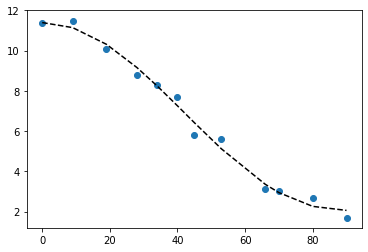

In [11]:
plt.scatter(X,y)
plt.plot(X,func1(X,*popt_func1),'k--')

In [12]:
def func2(x, a, b, n, k):
    return a*np.cos(np.deg2rad(X+k))**n + b

In [13]:
popt_func2, pcov_func2 = optimize.curve_fit(func2, X, y, p0=[1, 0, 0, -5])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


In [14]:
print('Value for k = ',popt_func2[-1])


Value for k =  -2.275585885558386e-06


In [15]:
from sklearn.metrics import r2_score
print('R^2 score :',r2_score(y,func1(X,*popt_func1)))

R^2 score : 0.9887736063413974


### Ratio of pathlengths (S/d)

In [16]:
Y_new = y/0.14    # To obtain flux formv the count

In [17]:
def D(theta,k):
    """ theta -> in degrees
        k = R/d 
    """
    return np.sqrt((k*np.cos(np.deg2rad(theta)))**2 + 2*k + 1) - k*np.cos(np.deg2rad(theta))

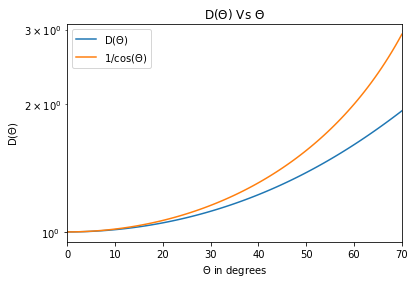

In [18]:
x = np.linspace(0,70,100)
F = D(x,4)
plt.plot(x,F, label=r'D($\Theta$)')
plt.yscale('log')
plt.xlabel(r'$\Theta$ in degrees')
plt.ylabel(r'D($\Theta$)')
plt.title(r'D($\Theta$) Vs $\Theta$')
f = 1/np.cos(np.deg2rad(x))
plt.plot(x,f, label=r'1/cos($\Theta$)')
plt.xlim([0,x[-1]])
plt.legend()

R2 Score is 0.85 at k = 9.090909090909092


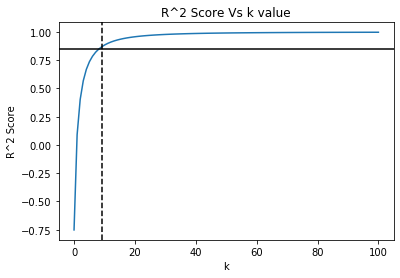

In [19]:
K = np.linspace(0,100,100)
R2_score = np.zeros(shape=K.shape)
for i,k in enumerate(K):
    F = D(x,k)
    f = 1/np.cos(np.deg2rad(x))
    R2_score[i] = r2_score(f,F)
plt.plot(K,R2_score)
plt.title('R^2 Score Vs k value')
plt.ylabel('R^2 Score')
plt.xlabel('k')
plt.axhline(y=0.85, ls='-', c='black')
min_R2 = np.where(R2_score>=0.85)[0][0] # Get minimum value for k s.t. R^2 score >=0.85
plt.axvline(x=K[min_R2], ls='--', c='black')

min_R2 = np.where(R2_score>=0.85)[0][0]
print('R2 Score is 0.85 at k = '+str(K[min_R2]))   # Value varies with maximum angle

In [20]:
n_0 = 3       #initial n value
R = 6371    #Earth's Radius

In [21]:
I0 = np.ones(shape=(2))
k = np.ones(shape=(2))
n = np.array([n_0 , 0.])
param = {"I0":I0, "k":k, "n":n}
i = 1

In [22]:
def flux_k(theta,I0,k):
    n = param["n"][0]
    return I0*D(theta,k)**-(n-1)

In [23]:
def flux_n(theta,I0,n):
    k = param["k"][0]
    return I0*D(theta,k)**-(n-1)

In [24]:
if i==1:
    popt_flux, pcov_flux = optimize.curve_fit(flux_k,X,Y_new,p0=[10,4])
    #Updating parameters
    param["I0"] = [popt_flux[0], perr[0]]
    param["k"] = [popt_flux[1], perr[1]]
else:
    popt_flux, pcov_flux = optimize.curve_fit(flux_n,X,Y_new,p0=[10,4])
    #Updating parameters
    param["I0"] = [popt_flux[0], perr[0]]
    param["n"] = [popt_flux[1], perr[1]]

perr = np.sqrt(np.diag(pcov_flux))         #Getting std error 
i ^= 1

print(param)

{'I0': [79.64910902573874, 0.33827630183132446], 'k': [3.795422387790475, 0.21471318840975576], 'n': array([3., 0.])}


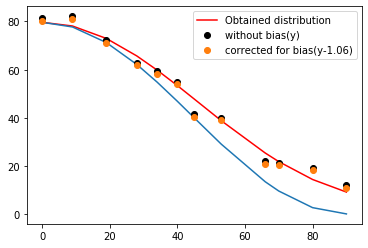

In [25]:
d_theory = 79.64*(D(X,174)**-(3-1))   # Theoretical distribution
d = 79.64*(D(X,3.79)**-(3-1))   # Obtained distribution
Y_New = Y_new-1.06       # Flux - Corrected for bias
plt.plot(X,d,'r', label='Obtained distribution')
plt.plot(X,d_theory)
plt.plot(X,Y_new,'ko', label='without bias(y)')
plt.plot(X,Y_New,'o',label='corrected for bias(y-1.06)')
plt.legend()

Chi2 is minimized(3.789205287600208) at b = 1.0610610610610611


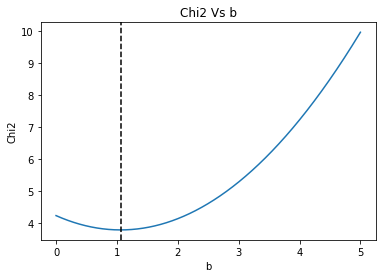

In [26]:
from scipy import stats

b = np.linspace(0,5,1000)
Chi2 = np.zeros(shape=b.shape)
for i in range(b.shape[0]):
    Y_obs = Y_new - b[i]
    Chi2[i] = stats.chisquare(f_obs= Y_obs, f_exp = d)[0]

    
plt.plot(b,Chi2)
plt.axvline(x=b[np.where(Chi2==Chi2.min())[0][0]], ls='--', c='black')
plt.title('Chi2 Vs b')
plt.xlabel('b')
plt.ylabel('Chi2')
print('Chi2 is minimized('+str(Chi2.min())+') at b = '+str(b[np.where(Chi2==Chi2.min())[0][0]]))

In [27]:


print(stats.chisquare(f_obs= Y_New, f_exp = d_theory))
print(stats.chisquare(f_obs= Y_new, f_exp = d))
print(stats.chisquare(f_obs= Y_New, f_exp = d))




Power_divergenceResult(statistic=620.8455272303086, pvalue=4.856931578933757e-126)
Power_divergenceResult(statistic=4.236439527918362, pvalue=0.9624831008507748)
Power_divergenceResult(statistic=3.7892048718710853, pvalue=0.9756823994007929)
